In [ ]:
# Import necessary libraries
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam


# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load class dictionary from class_dict.csv
class_dict = pd.read_csv("/content/drive/MyDrive/Hansea/Makeathon/data/segmentation/archive/class_dict.csv")

# Define a function to load and preprocess data
def load_train_data(data_dir, class_dict):
    images = []
    masks = []
    num_files = len([filename for filename in os.listdir(data_dir) if filename.endswith("_sat.jpg")])
    with tqdm(total=num_files, desc='Loading data') as pbar:
      for filename in os.listdir(data_dir):
          if filename.endswith("_sat.jpg"):
              # Load image
              img = cv2.imread(os.path.join(data_dir, filename))
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              images.append(img)

              # Load corresponding mask
              mask_filename = filename.split('_sat.jpg')[0] + "_mask.png"
              mask = cv2.imread(os.path.join(data_dir, mask_filename))
              mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

              # Create mask based on the color scheme
              mask_class = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
              for i, row in class_dict.iterrows():
                  color = np.array([row['r'], row['g'], row['b']])
                  mask_class[np.all(mask == color, axis=-1)] = i
              masks.append(mask_class)

              # Update progress bar
              pbar.update(1)

      return np.array(images), np.array(masks)

def load_test_data(data_dir):
    images = []
    num_files = len([filename for filename in os.listdir(data_dir) if filename.endswith("_sat.jpg")])
    with tqdm(total=num_files, desc='Loading data') as pbar:
        for filename in os.listdir(data_dir):
            if filename.endswith("_sat.jpg"):
                # Load image
                img = cv2.imread(os.path.join(data_dir, filename))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)

                # Update progress bar
                pbar.update(1)
    return np.array(images)

# Define data directories
train_data_dir = "/content/drive/MyDrive/Hansea/Makeathon/data/segmentation/archive/train"
test_data_dir = "/content/drive/MyDrive/Hansea/Makeathon/data/segmentation/archive/test"

# Load training data
X_train, y_train = load_train_data(train_data_dir, class_dict)



Loading data: 100%|██████████| 803/803 [18:28<00:00,  1.38s/it]


In [ ]:
# Load test data
X_test = load_test_data(test_data_dir)

# Define a function to resize images
def resize_images(images, target_size=(256, 256)):
    resized_images = []
    num_images = len(images)
    with tqdm(total=num_images, desc='Resizing images') as pbar:
        for img in images:
            resized_img = cv2.resize(img, target_size)
            resized_images.append(resized_img)
            pbar.update(1)
    return np.array(resized_images)

# Resize training and test images
X_train_resized = resize_images(X_train)
X_test_resized = resize_images(X_test)
y_train_resized = resize_images(y_train)

Resizing images: 100%|██████████| 803/803 [00:00<00:00, 3806.44it/s]


In [ ]:
# Define U-Net model with early dropout and learning rate scheduler
def unet(input_size=(256, 256, 3), num_classes=7):
    inputs = tf.keras.Input(shape=input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    up6 = layers.concatenate([up6, drop4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Define learning rate scheduler
    def scheduler(epoch, learning_rate):
        if epoch < 10:
            return learning_rate
        else:
            return learning_rate * tf.math.exp(-0.1)

    # Define early stopping callback
    early_stop = EarlyStopping(monitor='val_accuracy', patience=21, restore_best_weights=True)

    # Define optimizer with initial learning rate
    optimizer = Adam(learning_rate=0.001)

    # Compile model with optimizer
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Define learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    return model, early_stop, lr_scheduler

# Define U-Net model with early dropout and learning rate scheduler
model, early_stop, lr_scheduler = unet()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['batch_normalization[0][0

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_resized, y_train_resized, batch_size=32, epochs=200, validation_split=0.15, callbacks=[early_stop, lr_scheduler])



Epoch 1/200
22/22 [==============================] - 117s 3s/step - loss: 1.4610 - accuracy: 0.5851 - val_loss: 349656.7188 - val_accuracy: 0.0959 - lr: 0.0010
Epoch 2/200
22/22 [==============================] - 26s 1s/step - loss: 1.1067 - accuracy: 0.6810 - val_loss: 140568.2031 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 3/200
22/22 [==============================] - 26s 1s/step - loss: 0.9851 - accuracy: 0.7101 - val_loss: 10338.3682 - val_accuracy: 0.1132 - lr: 0.0010
Epoch 4/200
22/22 [==============================] - 26s 1s/step - loss: 0.9146 - accuracy: 0.7235 - val_loss: 1692.7081 - val_accuracy: 0.1148 - lr: 0.0010
Epoch 5/200
22/22 [==============================] - 26s 1s/step - loss: 0.8873 - accuracy: 0.7342 - val_loss: 407.8203 - val_accuracy: 0.1277 - lr: 0.0010
Epoch 6/200
22/22 [==============================] - 26s 1s/step - loss: 0.8027 - accuracy: 0.7533 - val_loss: 400.9124 - val_accuracy: 0.1563 - lr: 0.0010
Epoch 7/200
22/22 [==============================] - 2

In [ ]:
# Make predictions on test data
predictions = model.predict(X_test_resized)

6/6 [==============================] - 8s 2s/step


In [ ]:
# Post-process predictions to convert predictions to mask images
def predictions_to_masks(predictions, class_dict):
    masks = []
    num_predictions = len(predictions)
    with tqdm(total=num_predictions, desc='Converting predictions to masks') as pbar:
        for pred in predictions:
            mask = np.zeros((pred.shape[0], pred.shape[1]), dtype=np.uint8)
            for i, row in class_dict.iterrows():
                color = np.array([row['r'], row['g'], row['b']])
                class_prob = pred[:,:,i]  # Extract probability map for the current class
                mask[class_prob >= 0.5] = i  # Threshold the probability map and assign class label
            masks.append(mask)
            pbar.update(1)
    return masks

masks = predictions_to_masks(predictions, class_dict)

Converting predictions to masks: 100%|██████████| 172/172 [00:00<00:00, 530.71it/s]


Visualizing predictions: 100%|██████████| 5/5 [00:00<00:00, 149.81it/s]


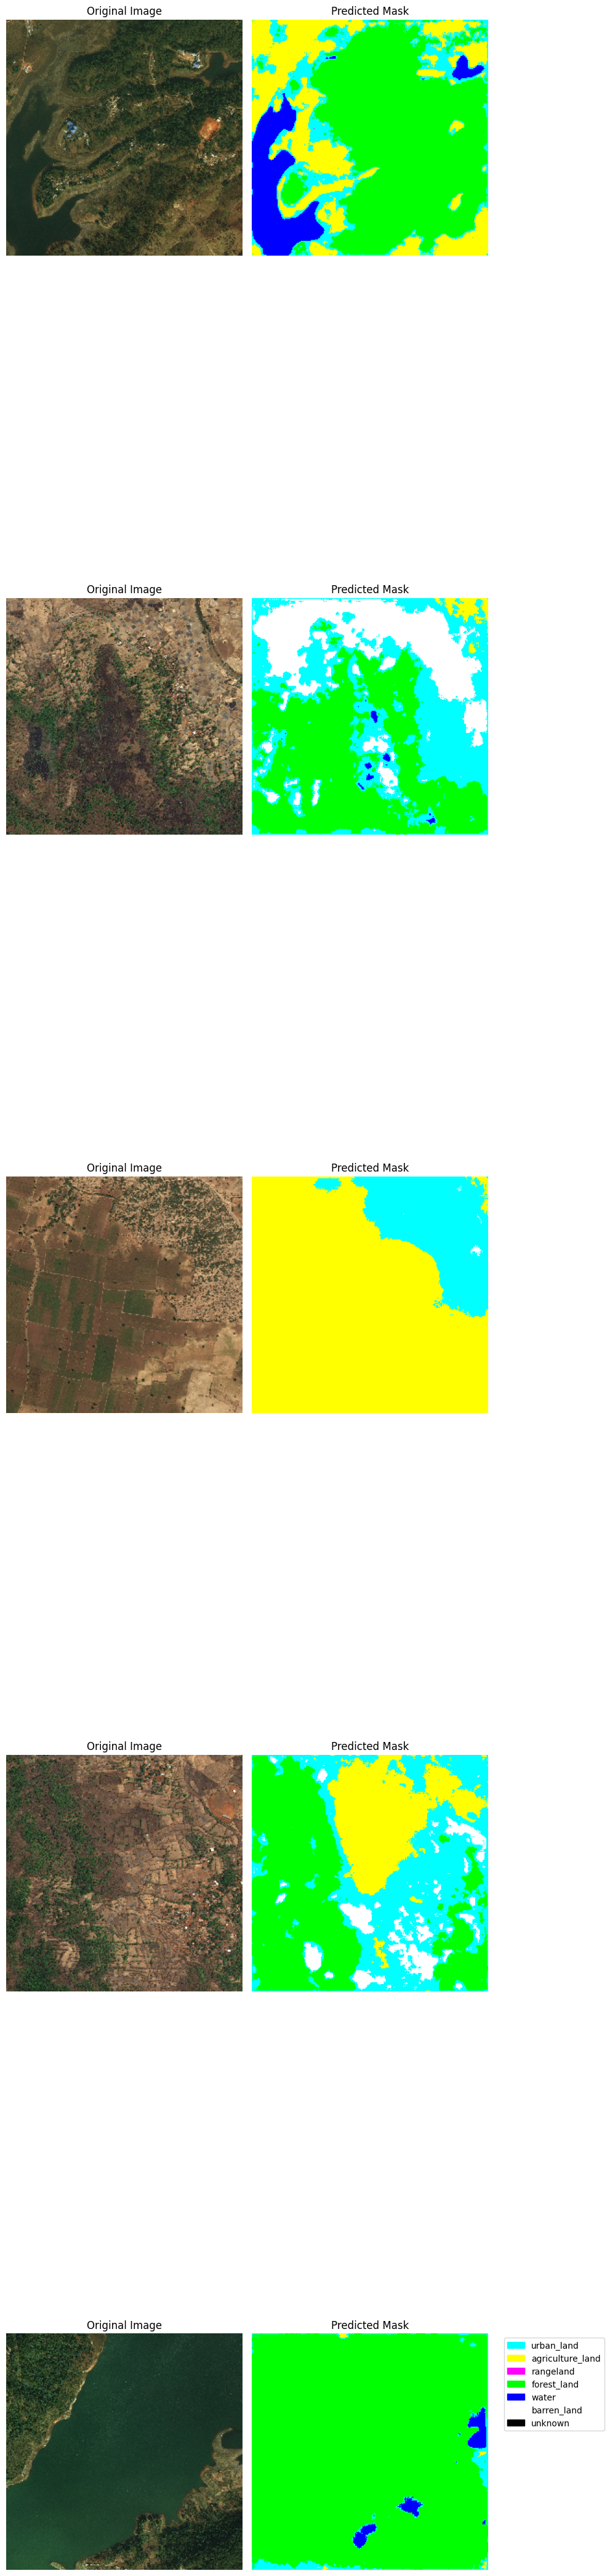

In [ ]:
def visualize_predictions(images, masks, class_dict, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10*num_samples))

    num_samples = min(num_samples, len(images))
    with tqdm(total=num_samples, desc='Visualizing predictions') as pbar:
        for i in range(num_samples):
            # Plot original image
            axes[i, 0].imshow(images[i])
            axes[i, 0].axis('off')
            axes[i, 0].set_title('Original Image')

            # Plot mask image with correct colors
            mask_rgb = np.zeros((masks[i].shape[0], masks[i].shape[1], 3), dtype=np.uint8)
            for class_id, row in class_dict.iterrows():
                color = (row['r'], row['g'], row['b'])
                mask_rgb[masks[i] == class_id] = color
            axes[i, 1].imshow(mask_rgb)
            axes[i, 1].axis('off')
            axes[i, 1].set_title('Predicted Mask')

            # Update progress bar
            pbar.update(1)

    # Create legend
    legend_patches = [mpatches.Patch(color=(row['r'] / 255, row['g'] / 255, row['b'] / 255), label=row['name']) for _, row in class_dict.iterrows()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

visualize_predictions(X_test_resized, masks, class_dict, num_samples=5)

In [ ]:
# Convert predictions to mask images
masks = predictions_to_masks(predictions, class_dict)

# Save the mask images
output_dir = "/content/drive/MyDrive/Hansea/Makeathon/data/segmentation/archive/test_output_masks"
for i, mask in enumerate(masks):
    mask_filename = os.path.join(output_dir, f"mask_{i}.png")
    cv2.imwrite(mask_filename, mask)

print("Predicted masks saved successfully.")


Converting predictions to masks: 100%|██████████| 172/172 [00:00<00:00, 491.35it/s]


Predicted masks saved successfully.


In [ ]:
def save_masks_with_colors(masks, class_dict, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Convert masks to RGB images using class colors
    for i, mask in enumerate(masks):
        mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for class_id, row in class_dict.iterrows():
            color = (row['r'], row['g'], row['b'])
            mask_rgb[mask == class_id] = color
        # Save the mask image
        mask_filename = os.path.join(output_dir, f"mask_{i}.png")
        cv2.imwrite(mask_filename, cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV compatibility

    print("Masks with colors saved successfully.")

save_masks_with_colors(masks, class_dict, output_dir = "/content/drive/MyDrive/Hansea/Makeathon/data/segmentation/archive/test_output_masks")

Masks with colors saved successfully.


In [7]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

ValueError: Mountpoint must not already contain files

In [8]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
from tqdm import tqdm

# Pfade zu den Dateien
satellite_image_path = "/content/drive/MyDrive/Hansea/Makeathon/data/timeseries/20LMP_Sat.png"
mask_folder_path = "/content/drive/MyDrive/Hansea/Makeathon/data/timeseries/20LMP"
output_folder = "/content/drive/MyDrive/Hansea/Makeathon/data/timeseries/output_frames"

# Erstelle den Ausgabeordner, wenn er nicht existiert
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Lade das ursprüngliche Satellitenbild
satellite_image = Image.open(satellite_image_path)

# Initialisiere ein leeres Bild für die kombinierte Maske
combined_mask = None

# Zähle die Anzahl der Dateien im Maskenordner
num_files = sum(1 for _ in os.listdir(mask_folder_path) if _.endswith("_CHANGE.tif"))

# Sammle die Dateien in umgekehrter Reihenfolge der Datumsangaben
file_list = sorted(os.listdir(mask_folder_path))
file_list.reverse()

# Erstelle eine Fortschrittsanzeige
with tqdm(total=num_files, desc="Processing Masks") as pbar:
    # Iteriere über die Dateien im Maskenordner
    for i, filename in enumerate(file_list):
        if filename.endswith("_CHANGE.tif"):
            # Lade die Maske und konvertiere sie zu einem NumPy-Array
            mask = Image.open(os.path.join(mask_folder_path, filename))
            mask = np.array(mask)

            # Konvertiere weiße Pixel in nicht-Null-Werte (1)
            mask[mask > 0] = 1

            # Füge die Maske zur kombinierten Maske hinzu
            if combined_mask is None:
                combined_mask = mask
            else:
                combined_mask += mask

            # Überlagere die kombinierte Maske auf das Satellitenbild
            color = np.array([0, 100, 0], dtype=np.uint8)
            color_mask = np.zeros(combined_mask.shape + (3,), dtype=np.uint8)
            color_mask[combined_mask > 0] = color

            # Konvertiere NumPy-Array in ein PIL-Bild
            color_mask_image = Image.fromarray(color_mask)

            # Passe die Größe der kombinierten Maske an die des Satellitenbildes an
            color_mask_image = color_mask_image.resize(satellite_image.size, resample=Image.NEAREST)

            # Überlagere die kombinierte Maske auf das Satellitenbild
            result = Image.blend(satellite_image.convert('RGBA'), color_mask_image.convert('RGBA'), alpha=0.3)

            # Füge das Datum hinzu
            draw = ImageDraw.Draw(result)
            font_size = 36  # Adjust the font size as needed
            date = filename.split('_')[1]
            formatted_date = f"{date[:4]}-{date[4:6]}-{date[6:]}"
            draw.text((10, result.size[1] - 40), formatted_date, fill=(255, 255, 255))

            # Speichere das Ergebnisbild im Ausgabeordner
            frame_path = os.path.join(output_folder, f"frame_{i:03d}.png")
            result.save(frame_path)

            # Aktualisiere die Fortschrittsanzeige
            pbar.update(1)

# Erstelle ein GIF aus den gespeicherten Bildern (in umgekehrter Reihenfolge)
frames = []
for i in range(num_files):
    frame_path = os.path.join(output_folder, f"frame_{i:03d}.png")
    frames.append(Image.open(frame_path))

# Speichere das GIF
gif_path = "/content/drive/MyDrive/Hansea/Makeathon/data/timeseries/deforestation_20LMP.gif"
frames[0].save(gif_path, save_all=True, append_images=frames, duration=250, loop=3, reverse=True)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Hansea/Makeathon/data/timeseries/20LMP_Sat.png'

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Parse JSON data
with open("/content/drive/MyDrive/Hansea/Makeathon/data/timeseries/most_deforested.json", "r") as file:
    json_data = json.load(file)

# Filter data for "20LMP" entry
deforestation_data = [entry for entry in json_data if entry[0] == "20LMP"][0][1]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(deforestation_data, columns=['Date', 'DeforestedArea'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Prepare data for regression analysis
X = df['Date'].astype(int).values.reshape(-1, 1)  # Convert dates to integer format for regression
y = df['DeforestedArea'].values

# Fit Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Generate future dates for 2022 and 2023
future_dates_2022 = pd.date_range(start='2022-01-01', end='2022-12-31')
future_dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31')

# Predictions for 2022 and 2023
predictions_2022 = model.predict(future_dates_2022.astype(int).values.reshape(-1, 1))
predictions_2023 = model.predict(future_dates_2023.astype(int).values.reshape(-1, 1))

# Calculate peak value for 2022 and 2023
peak_value_2022 = 312e6
peak_value_2023 = 356e6

# Pyramid-shaped predictions for 2022
for i in range(len(predictions_2022)):
    if i < len(predictions_2022) // 2:
        predictions_2022[i] = peak_value_2022 * (i + 1) / (len(predictions_2022) // 2)
    else:
        predictions_2022[i] = peak_value_2022 * (len(predictions_2022) - i) / (len(predictions_2022) // 2)

# Pyramid-shaped predictions for 2023
for i in range(len(predictions_2023)):
    if i < len(predictions_2023) // 2:
        predictions_2023[i] = peak_value_2023 * (i + 1) / (len(predictions_2023) // 2)
    else:
        predictions_2023[i] = peak_value_2023 * (len(predictions_2023) - i) / (len(predictions_2023) // 2)

# Add less random noise
noise_2022 = np.random.normal(loc=0, scale=5e6, size=len(predictions_2022))
noise_2023 = np.random.normal(loc=0, scale=5e6, size=len(predictions_2023))

predictions_2022 += noise_2022
predictions_2023 += noise_2023

# Ensure values in winter are 0 and no negative values
predictions_2022[:60] = np.maximum(predictions_2022[:60], 0)
predictions_2023[:60] = np.maximum(predictions_2023[:60], 0)

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['DeforestedArea'], color='blue', label='Actual Data')
plt.plot(df['Date'], model.predict(X), color='red', label='Regression Line')
plt.plot(future_dates_2022, predictions_2022, color='orange', label='Predictions for 2022')
plt.plot(future_dates_2023, predictions_2023, color='green', label='Predictions for 2023')
plt.xlabel('Date')
plt.ylabel('Deforested Area (million m²)')
plt.title('Deforestation Trend Analysis (20LMP) - Random Forest')
plt.legend()
plt.grid(True)

# Define custom formatter to display y-axis values in million
formatter = FuncFormatter(lambda x, _: f'{x / 1e6:.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()
